In [1]:
%%capture
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import scvi
import scipy
from numpy import var, mean, sqrt
from scipy.stats import ttest_ind

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)

In [3]:
os.getcwd()

'/home/joe/Repositories/mTEC-eTAC-atlases/mTEC-analysis'

## Data paths

### demeter

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

In [8]:
adata = sc.read(f"{processedDataPath}/mTEC_analysis/h5ad_files/merged_thymus_atlas.h5ad")
model = scvi.model.SCVI.load(f"{processedDataPath}/mTEC_analysis/scVI_models/merged_thymus_atlas", adata=adata)

INFO     File /mnt/iacchus/joe/processed_data//mTEC_analysis/scVI_models/merged_thymus_atlas/model.pt already      
         downloaded                                                                                                


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# DE

In [42]:
immatureTECDE = model.differential_expression(
    adata=adata[adata.obs.genotype == "WT"],
    groupby="cell_type_aggregated",
    group1="Immature TECs 2",
    batch_correction=True,
)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
DE...: 100%|██████████| 1/1 [00:07<00:00,  7.79s/it]


In [43]:
filteredDE = immatureTECDE[immatureTECDE.bayes_factor > 2].copy()
filteredDE = filteredDE[filteredDE.lfc_mean > 1]
filteredDE = filteredDE[filteredDE.non_zeros_proportion1 > 0.05]

In [44]:
# Filter genes with low average normalized expression
expressionFiltered = pd.DataFrame(
    pd.DataFrame(
        adata[:, filteredDE.index].layers["scVI_normalized"],
        columns=filteredDE.index
    ).quantile(0.99)
)
expressionFiltered = expressionFiltered[expressionFiltered[0.99] > 1]
filteredDE = filteredDE[filteredDE.index.isin(filteredDE.index)]

In [45]:
TFs = list(pd.read_csv("/home/joe/Repositories/M-cells/mouse_ensemble_tfs_from_lambertetal_isyes.unique.csv", header=None)[1])
TFs = [i for i in TFs if i in adata.var_names]

In [46]:
filteredTFs = filteredDE[filteredDE.index.isin(TFs)].sort_values(by="lfc_mean", ascending=False)
filteredTFs

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
Zeb1    0.975170      0.024830      3.670567  0.000091  0.000023   
Bnc2    0.962355      0.037645      3.241178  0.000034  0.000008   
Trp63   0.955146      0.044854      3.058455  0.000356  0.000101   
Scx     0.959151      0.040849      3.156165  0.000090  0.000034   
Zfp608  0.944133      0.055867      2.827292  0.000083  0.000025   
...          ...           ...           ...       ...       ...   
Zfp236  0.881658      0.118342      2.008225  0.000041  0.000022   
Topors  0.905086      0.094914      2.255060  0.000080  0.000041   
Zfp113  0.890268      0.109732      2.093485  0.000036  0.000018   
Wiz     0.886864      0.113136      2.059103  0.000038  0.000020   
Ikzf2   0.884862      0.115138      2.039299  0.000060  0.000036   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
Zeb1             0.0   0.25  2.486956    2.484632  1.354744  ...   0.352403   
Bnc2             0.0   0.25  2.477828    2.475192  1.560622  ...   0.124679   
Trp63            0.0   0.25  2.368279    2.521436  1.432600  ...   1.215256   
Scx              0.0   0.25  2.352863    2.483057  2.081839  ...   0.325267   
Zfp608           0.0   0.25  2.323139    2.153487  1.673961  ...   0.260726   
...              ...    ...       ...         ...       ...  ...        ...   
Zfp236           0.0   0.25  1.019837    1.005259  0.805392  ...   0.131280   
Topors           0.0   0.25  1.019809    0.993106  0.665110  ...   0.295196   
Zfp113           0.0   0.25  1.008465    1.006890  0.748658  ...   0.116978   
Wiz              0.0   0.25  1.008152    0.976952  0.675306  ...   0.121379   
Ikzf2            0.0   0.25  1.003606    0.986881  1.075241  ...   0.204620   

        raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
Zeb1     0.236082               0.187752               0.128970   
Bnc2     0.085065               0.070407               0.044220   
Trp63    1.078495               0.513385               0.394782   
Scx      0.175980               0.211588               0.075888   
Zfp608   0.161181               0.180051               0.108142   
...           ...                    ...                    ...   
Zfp236   0.281873               0.114045               0.212686   
Topors   0.691852               0.199853               0.391363   
Zfp113   0.190018               0.102310               0.156500   
Wiz      0.206258               0.108911               0.173594   
Ikzf2    0.328426               0.143748               0.186370   

        raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
Zeb1                0.856026              0.182052            True   
Bnc2                0.257549              0.072692            True   
Trp63               3.629864              0.915207            True   
Scx                 1.145896              0.190467            True   
Zfp608              0.783069              0.153995            True   
...                      ...                   ...             ...   
Zfp236              0.352763              0.218945           False   
Topors              0.761563              0.491588           False   
Zfp113              0.398369              0.144566           False   
Wiz                 0.398519              0.170305           False   
Ikzf2               0.547667              0.257078           False   

                     comparison           group1 group2  
Zeb1    Immature TECs 2 vs Rest  Immature TECs 2   Rest  
Bnc2    Immature TECs 2 vs Rest  Immature TECs 2   Rest  
Trp63   Immature TECs 2 vs Rest  Immature TECs 2   Rest  
Scx     Immature TECs 2 vs Rest  Immature TECs 2   Rest  
Zfp608  Immature TECs 2 vs Rest  Immature TECs 2   Rest  
...                         ...              ...    ...  
Zfp236  Immature TECs 2 vs Rest  Immature TECs 2   Rest  
Topors  Immature TECs 2 vs Rest  Immature TECs 2   Rest  
Zfp113  Immature TECs 2 vs Rest  Immature TECs 2   Rest  
Wiz     Immature

In [47]:
filteredTFs.to_csv("Mathis_immature_TECs_DE_TFs.csv")

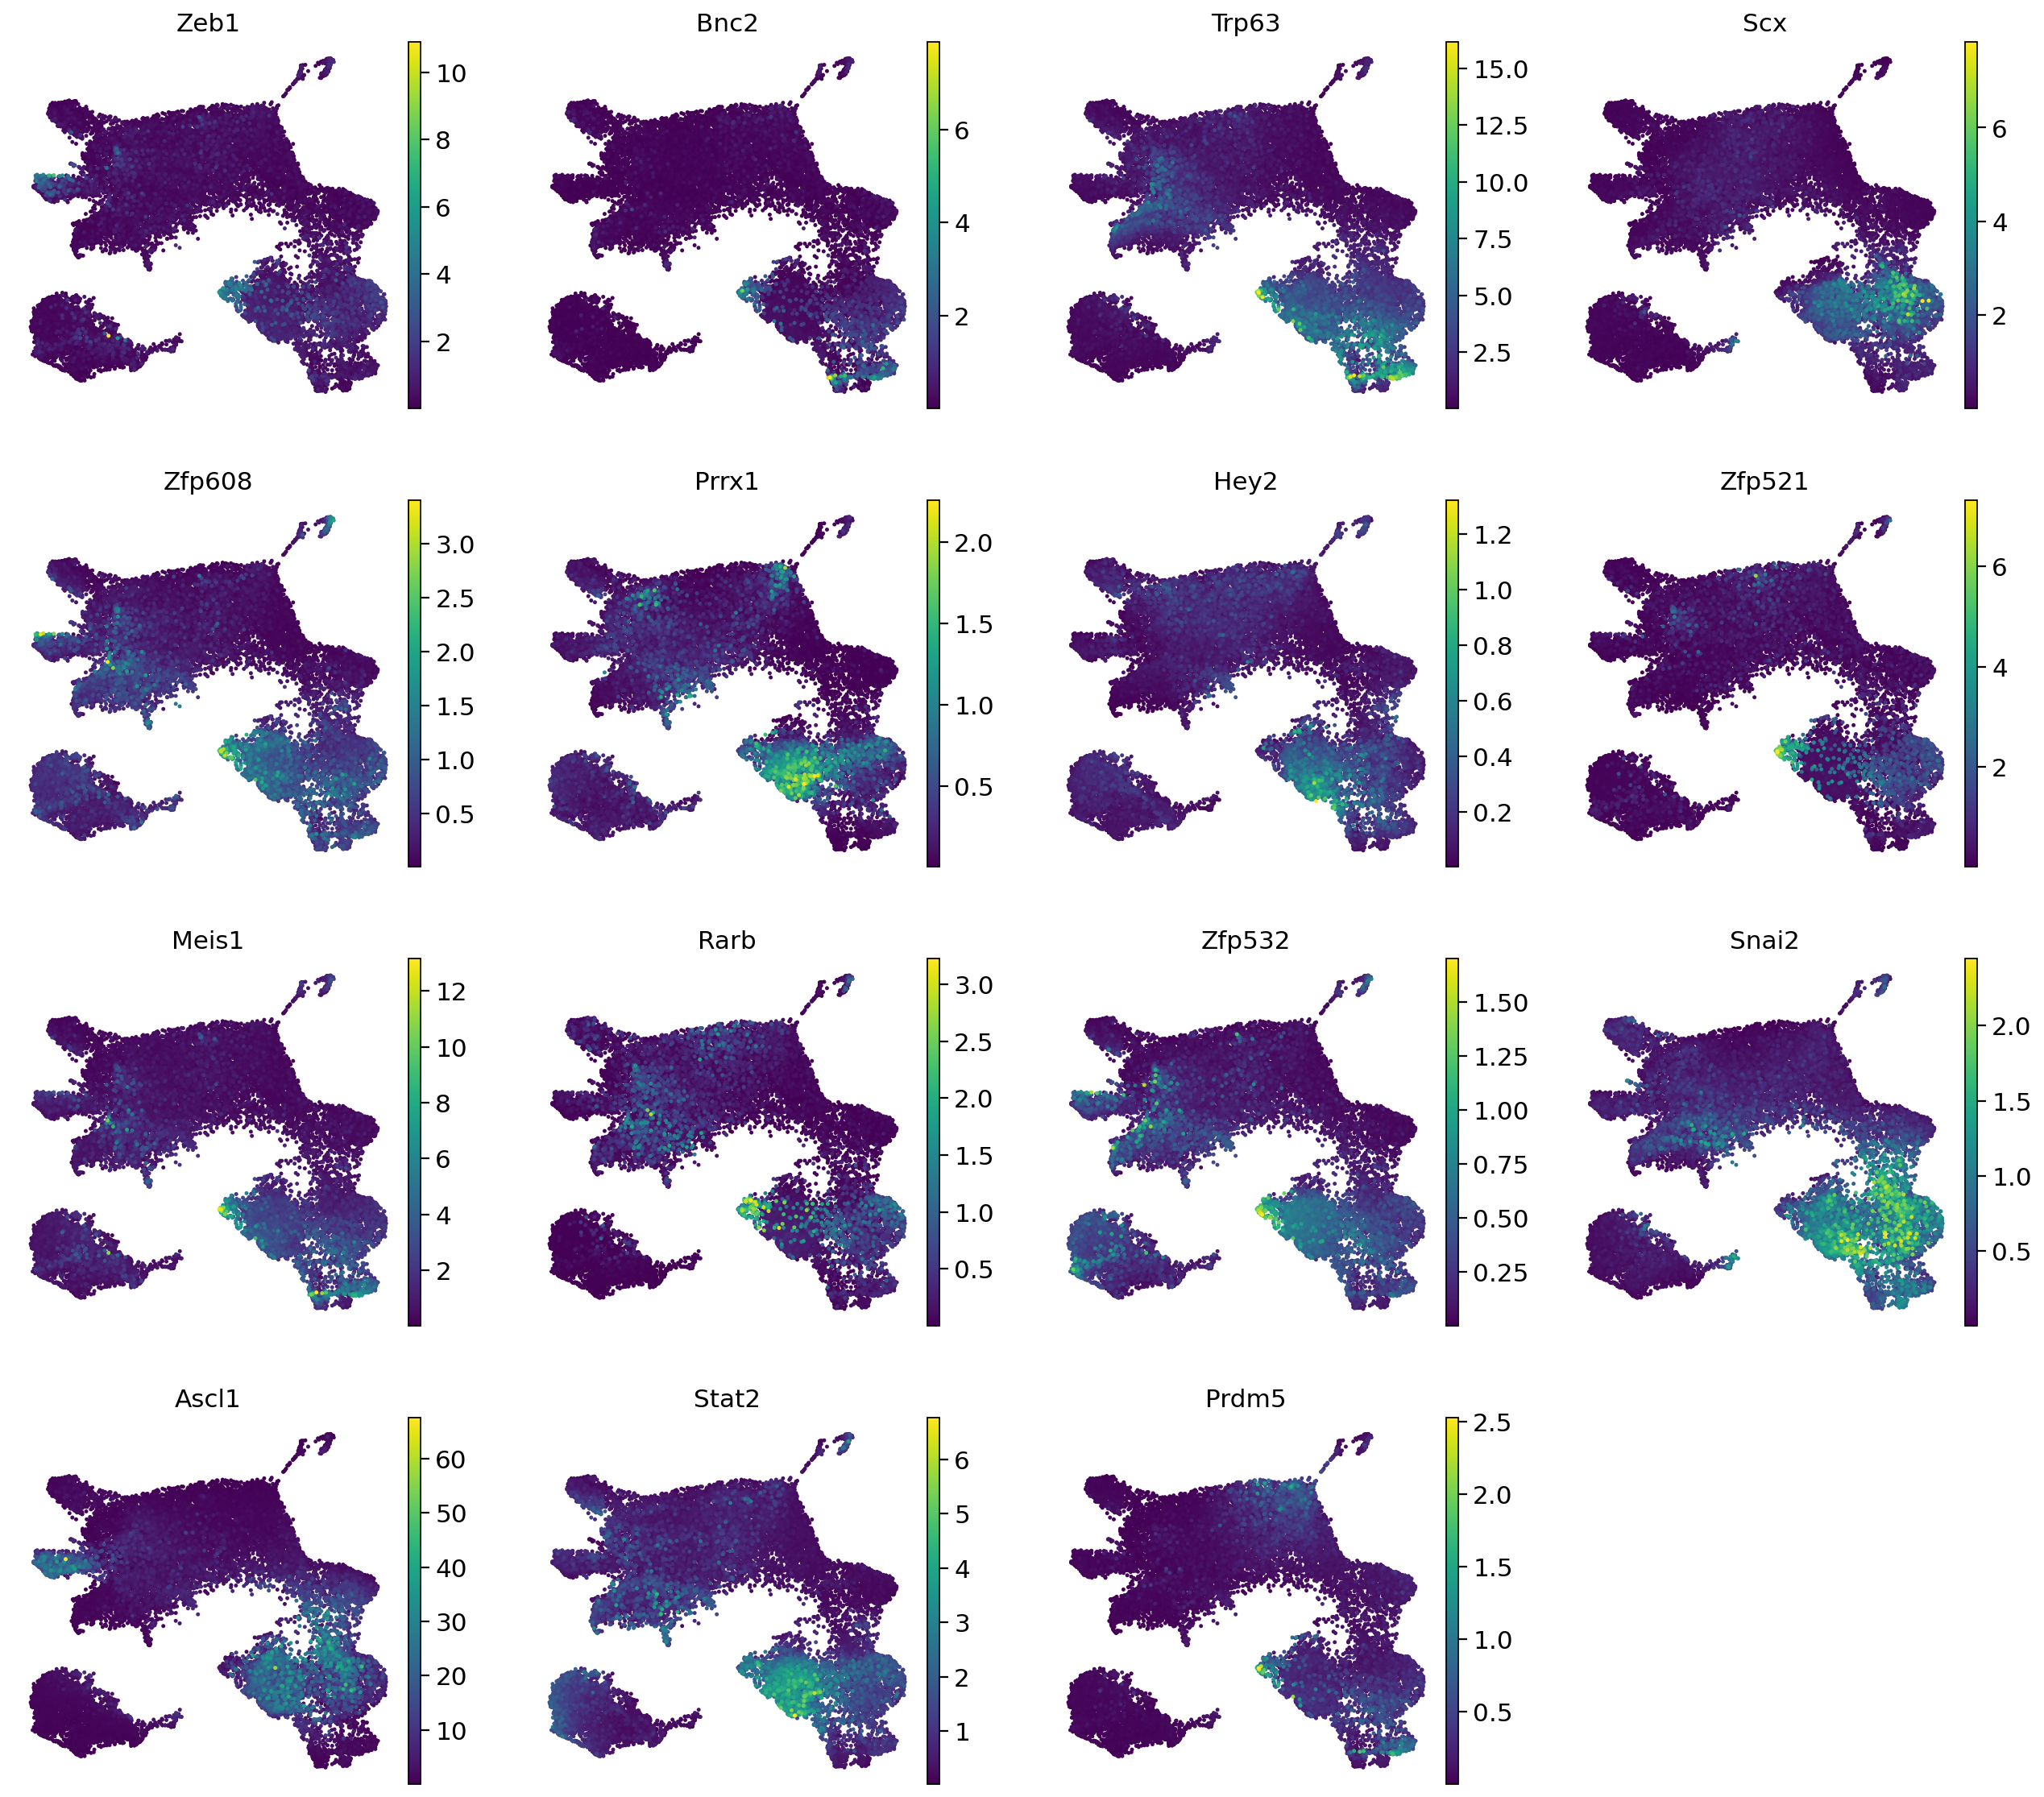

In [53]:
sc.pl.umap(
    adata[adata.obs.genotype == "WT"],
    color = filteredTFs.head(15).index,
    layer="scVI_normalized",
    s=20
)

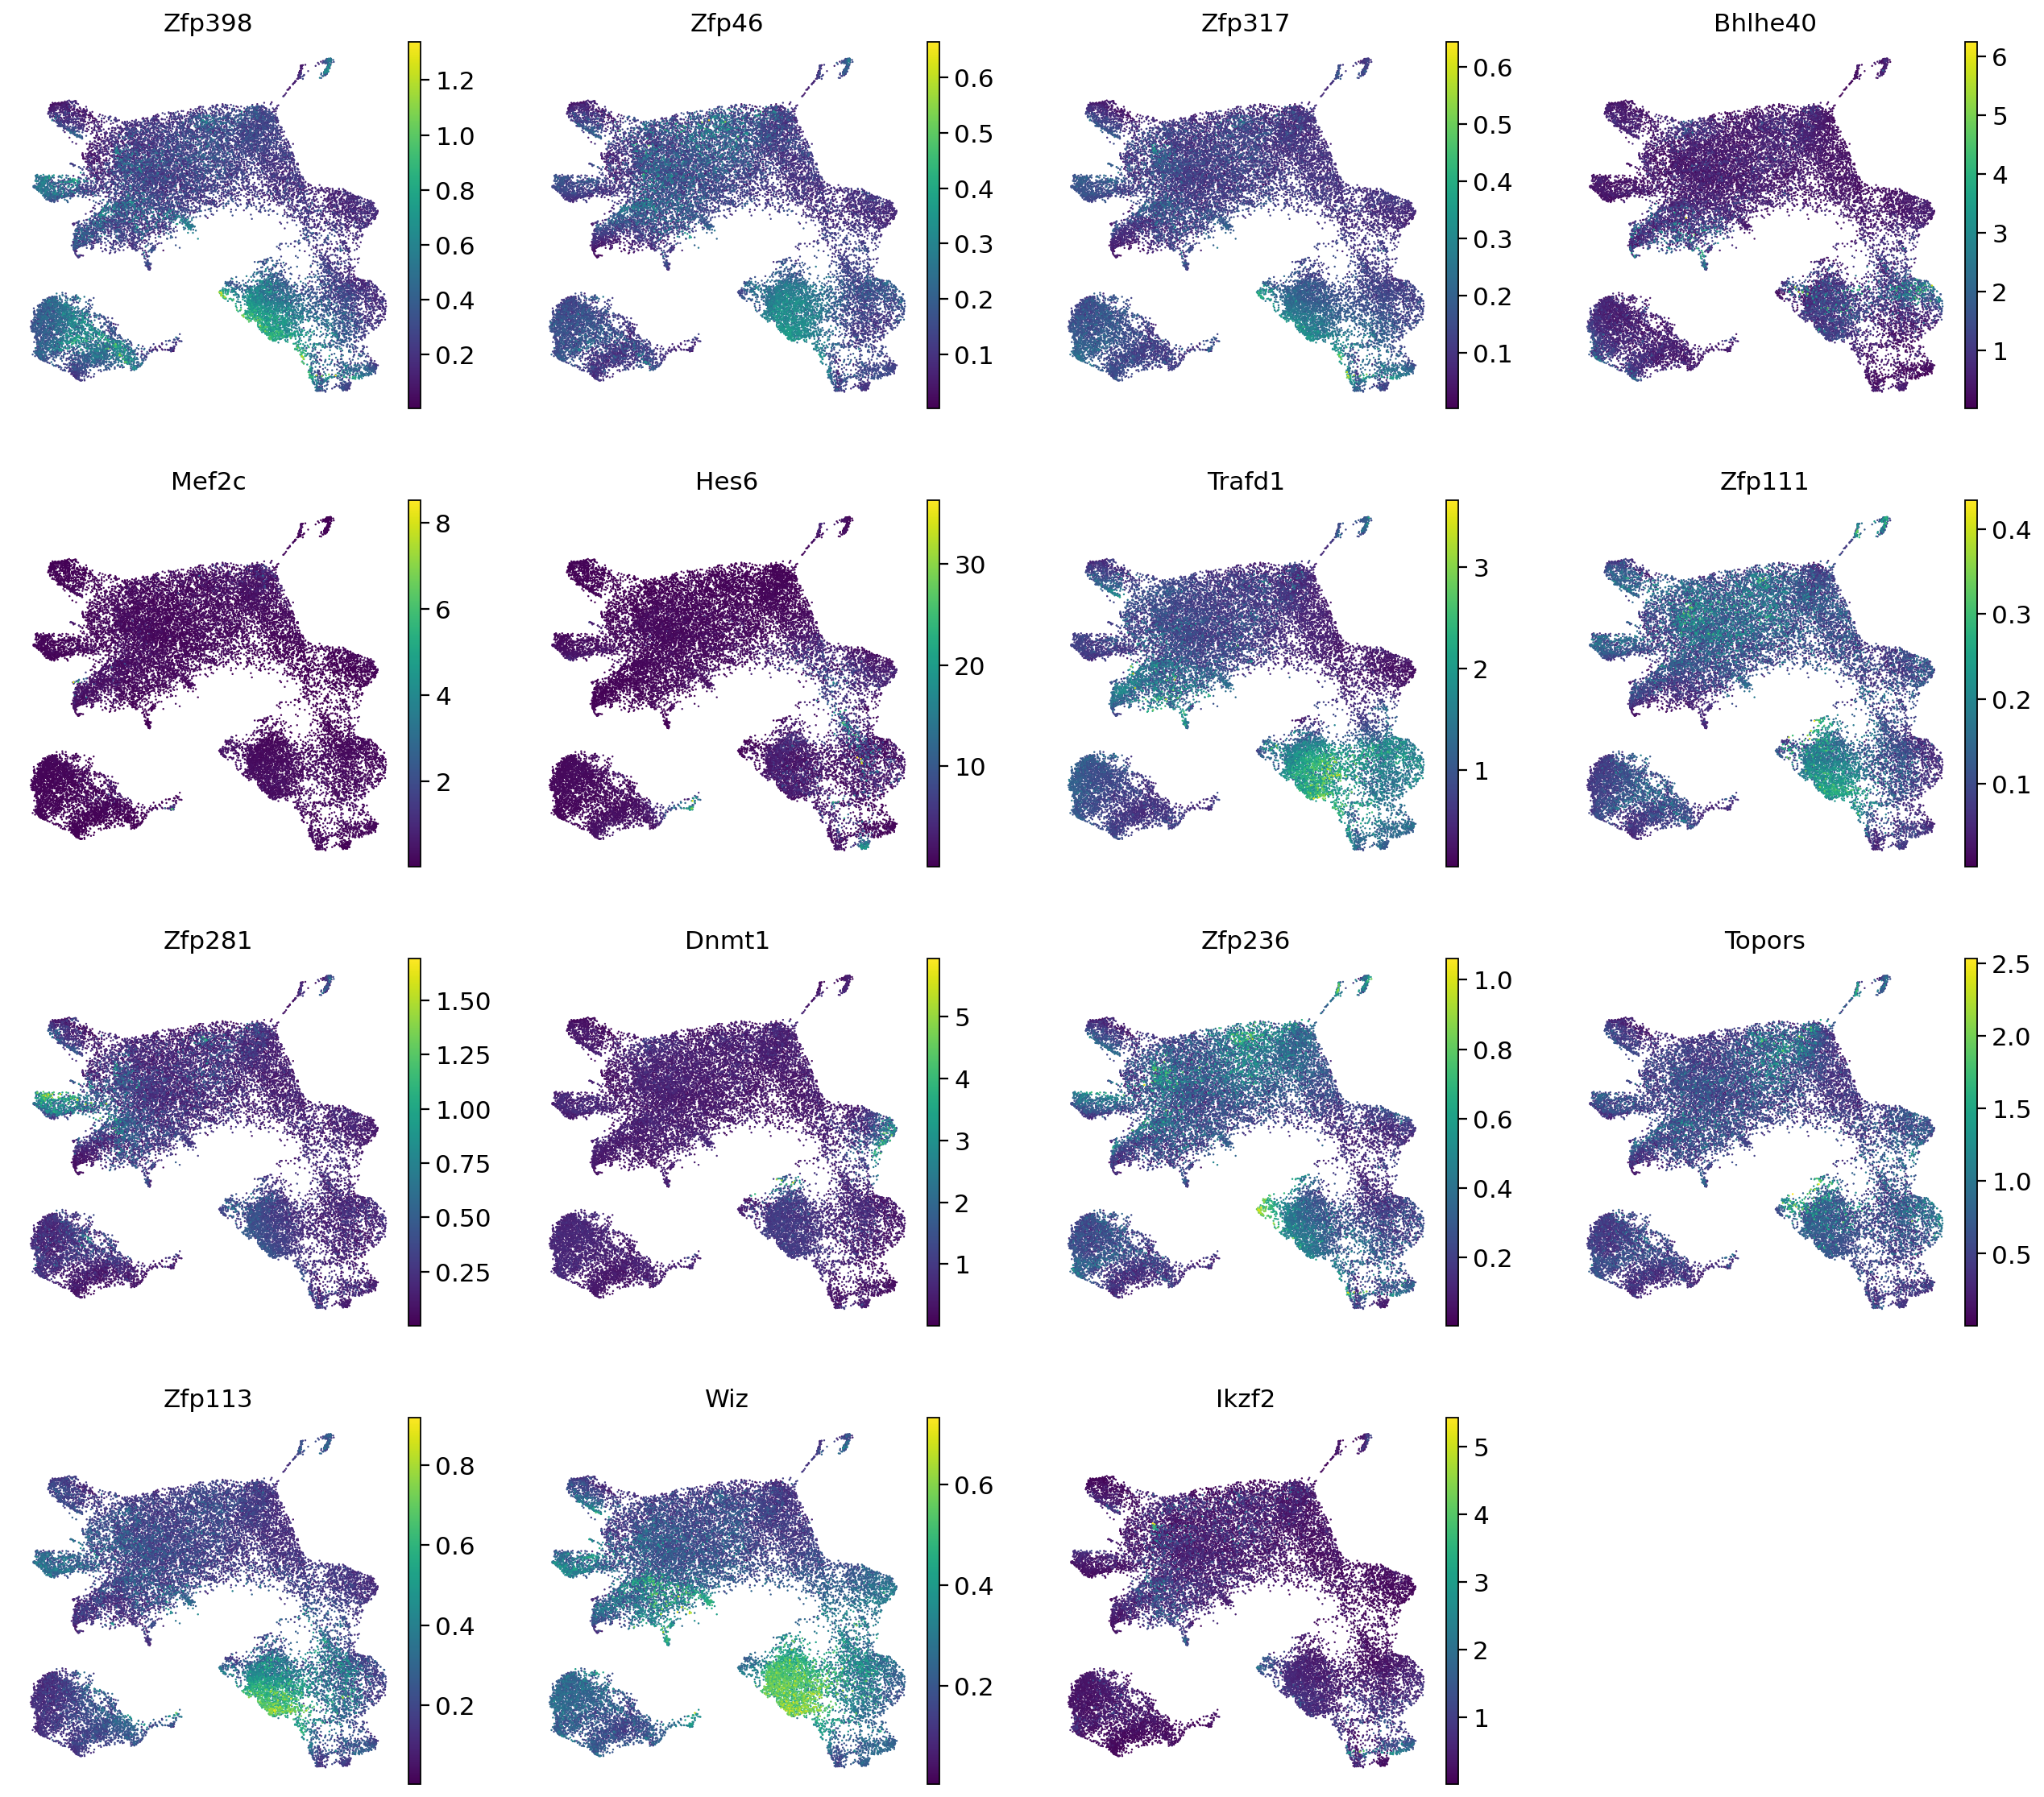

In [49]:
sc.pl.umap(
    adata[adata.obs.genotype == "WT"],
    color = filteredTFs.tail(15).index,
    layer="scVI_normalized"
)